In [28]:
'''Load Packages'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [29]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [30]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
      
    temp = np.sort(rank)
    temp = np.concatenate((temp[::2], temp[1::2][::-1]))
    rank = random.sample(range(1, len(temp)+1),len(temp))
    
    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

In [31]:
def cat_to_names(df,references):
    ref = df.columns[df.columns.isin(references.keys())].to_list()
    temp_df = df.copy()
    for key in ref:
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df

In [32]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
new_df = pd.read_csv('newdata.csv')

In [36]:
carmax_df['job_assign'] = new_df['job_assign']
carmax_df['customer_income'] = new_df['new_income']
carmax_df['customer_age'] = new_df['new_ages']

In [40]:
cluster_df = carmax_df.copy().drop(['customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used',
                             'purchase_price_UB','purchase_class'], axis=1)

In [41]:
cluster_df.head()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,job_assign
0,DODGE,CHARGER,2012,15001.0,1,1,40001 - 60000,U,1,Twenties,UNITED STATES,"Life, Physical, and Social Science Technicians..."
1,FORD,F150,2007,15001.0,0,0,0 - 20000,F,0,Fifties,UNITED STATES,"Entertainers and Performers, Sports and Relate..."
2,BMW,328,2010,25001.0,1,1,60001 - 80000,F,0,Forties,GERMANY,Farm Labor Contractors
3,LEXUS,GS 300,2003,10001.0,0,1,20001 - 40000,M,0,Twenties,JAPAN,Painting Workers
4,CHEVROLET,CRUZE,2012,15001.0,1,1,120001 - 140000,M,1,Thirties,UNITED STATES,Natural Sciences Managers


In [42]:
## references of transformation for later 
references = {}

# transform to numerical values 
for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

In [43]:
cluster_df['purchase_class'] = carmax_df['purchase_class']

In [44]:
sedan = cluster_df[cluster_df.purchase_class=='sedan'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
truck = cluster_df[cluster_df.purchase_class=='truck'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
suv = cluster_df[cluster_df.purchase_class=='suv'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
wagon = cluster_df[cluster_df.purchase_class=='wagon'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
van = cluster_df[cluster_df.purchase_class=='van'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
coupe = cluster_df[cluster_df.purchase_class=='coupe'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
convertible = cluster_df[cluster_df.purchase_class=='convertible'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)

vehicle_classes = [sedan,truck,suv,wagon,van,coupe,convertible]

### Elbow Method to determine k for each cluster of vehicle class

sedan
1 : 3.3719475041904574
2 : 3.2088321091400616
3 : 3.083550746430383
4 : 2.99156042101048
5 : 2.9311348136465343
6 : 2.88110324877607
7 : 2.811393178249283
8 : 2.7679776052797327
9 : 2.719987569267879
10 : 2.683007973053679
11 : 2.659588219439561
12 : 2.627390013221621
13 : 2.602799500530436
14 : 2.584222134594397


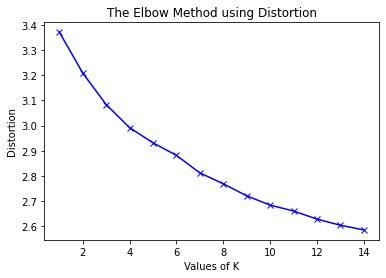

1 : 1813080.0000000193
2 : 1656103.8377125415
3 : 1533161.279412733
4 : 1448793.9906244797
5 : 1357540.8389648043
6 : 1306067.9014512526
7 : 1249233.401446546
8 : 1203000.7477060468
9 : 1167133.939500608
10 : 1140635.0524245095
11 : 1116436.6929782976
12 : 1094578.2266155882
13 : 1072368.6390006843
14 : 1054251.5998177922


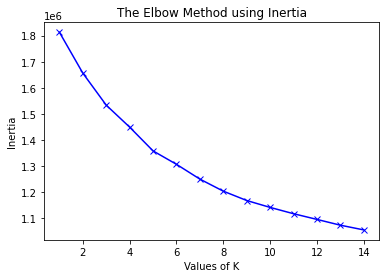

truck
1 : 3.384965127910363
2 : 3.1496795831116153
3 : 3.0167518052545996
4 : 2.9073633582941243
5 : 2.849847545855096
6 : 2.764434577898261
7 : 2.7044236746355135
8 : 2.6549200107753275
9 : 2.6090507894730273
10 : 2.573915908436637
11 : 2.5423796097858067
12 : 2.5140600388808356
13 : 2.476311098468038
14 : 2.4493367709918856


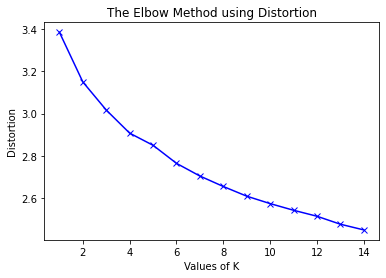

1 : 345203.9999999977
2 : 302376.30784764444
3 : 279565.8549230054
4 : 260441.6846183105
5 : 243983.48892233448
6 : 229115.3198835762
7 : 220461.4650994983
8 : 212786.5223126374
9 : 206184.43517393066
10 : 200940.76778710866
11 : 196589.33596233788
12 : 192178.0107699655
13 : 186333.02328200248
14 : 182501.45215019787


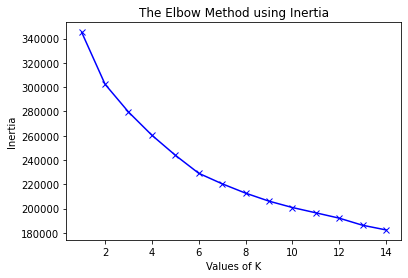

suv
1 : 3.388266322192043
2 : 3.2276519798792633
3 : 3.1091441219857234
4 : 3.047959330726487
5 : 2.9540644302380024
6 : 2.8849073725947
7 : 2.832112969407156
8 : 2.795833222540993
9 : 2.7562510824676054
10 : 2.718618586748181
11 : 2.6835025416874174
12 : 2.6625372170430412
13 : 2.6295354413896352
14 : 2.6030946850497143


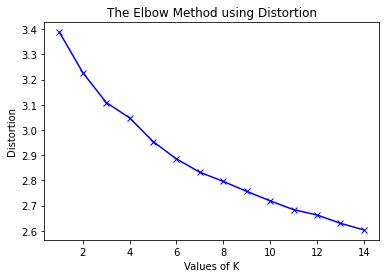

1 : 1096440.0000000033
2 : 996578.1660902257
3 : 928423.4770628101
4 : 871898.2130000547
5 : 822500.0903509787
6 : 784982.5846470008
7 : 758480.6519140769
8 : 737060.0838667536
9 : 717003.6192433628
10 : 698231.535288988
11 : 683747.7200928
12 : 670751.5531635236
13 : 657929.4914665746
14 : 645837.1497697459


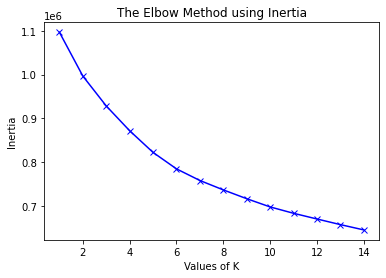

wagon
1 : 3.3846597035351147
2 : 3.1927958710177062
3 : 3.075385969434739
4 : 3.0133718087270656
5 : 2.918307293168073
6 : 2.8453290356482657
7 : 2.79670643456245
8 : 2.746593438663078
9 : 2.7072211457933295
10 : 2.665422207510498
11 : 2.6350851657606893
12 : 2.6032659163649874
13 : 2.5753233618040983
14 : 2.5576597432641677


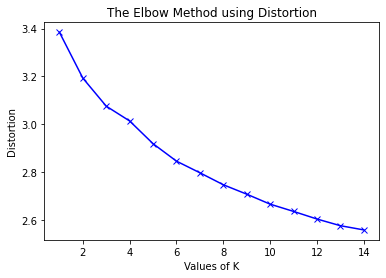

1 : 331212.00000000134
2 : 297915.0335291149
3 : 277248.00745348155
4 : 260486.82738832975
5 : 244767.51198092618
6 : 232379.40053258356
7 : 224361.44518266566
8 : 216960.03760592267
9 : 210922.90008963653
10 : 205367.48846704
11 : 200933.7598051295
12 : 195709.04958812296
13 : 192085.2721974384
14 : 188889.98948838707


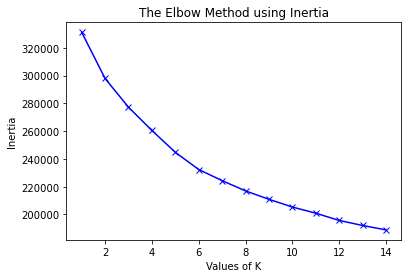

van
1 : 3.38149834856647
2 : 3.2000917491816585
3 : 3.0665762062414466
4 : 3.0043501234641936
5 : 2.9057572259070503
6 : 2.8273683934056675
7 : 2.7664084582148636
8 : 2.709830948980849
9 : 2.6767487711139375
10 : 2.6444068715485116
11 : 2.61119667551307
12 : 2.5800661582699176
13 : 2.551634741188429
14 : 2.523781160899449


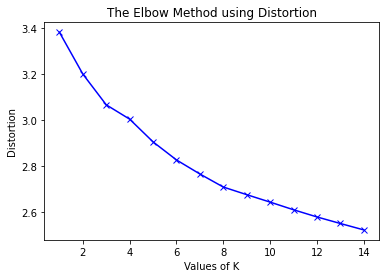

1 : 169559.99999999924
2 : 152326.4604580294
3 : 140251.59554749416
4 : 131528.03830037644
5 : 123564.39767933672
6 : 117308.68431221083
7 : 111945.70875995475
8 : 107854.55957088091
9 : 105147.75497232589
10 : 102737.4235107798
11 : 100337.32495011858
12 : 98409.89756758242
13 : 96616.36091889859
14 : 94629.88531499653


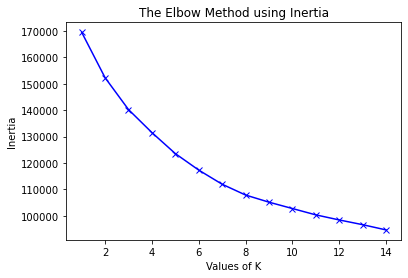

coupe
1 : 3.3572375136946895
2 : 3.128194024926721
3 : 2.9962432271370516
4 : 2.8849262735017818
5 : 2.82547396280945
6 : 2.7284205015683316
7 : 2.6754218017580746
8 : 2.6264538627305996
9 : 2.5861597512810772
10 : 2.5433657130595044
11 : 2.510573704508034
12 : 2.4784497522062
13 : 2.4462021153350646
14 : 2.428422914137532


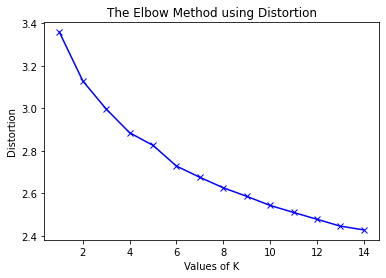

1 : 294360.00000000163
2 : 257794.052697942
3 : 235941.8114775281
4 : 219862.80266002665
5 : 205414.04593359987
6 : 193438.3055653141
7 : 186346.106683185
8 : 179738.54638748273
9 : 174402.28662644135
10 : 169043.5990993238
11 : 164796.17173357581
12 : 161388.17756307486
13 : 157767.61112066288
14 : 154484.93772579916


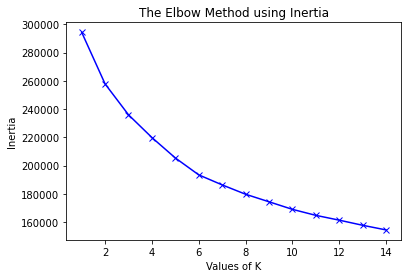

convertible
1 : 3.37342226184638
2 : 3.1925953237347824
3 : 3.059418274213124
4 : 2.9968391917336437
5 : 2.910563901670758
6 : 2.8373208903087663
7 : 2.759403603309306
8 : 2.7121292349228834
9 : 2.660227053955501
10 : 2.6259213331877183
11 : 2.590845883628237
12 : 2.5626713218876485
13 : 2.5295794628858252
14 : 2.491785114141427


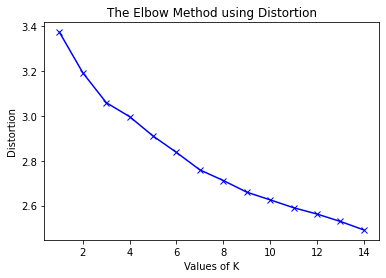

1 : 220632.00000000128
2 : 199154.6575957108
3 : 183640.70899265903
4 : 172230.4898391513
5 : 163430.35801251087
6 : 154422.56043910593
7 : 147278.4463890127
8 : 141894.06600213848
9 : 137141.3577434487
10 : 133396.186608228
11 : 130281.63761991641
12 : 127170.5763807945
13 : 124177.32447426686
14 : 121529.80729488198


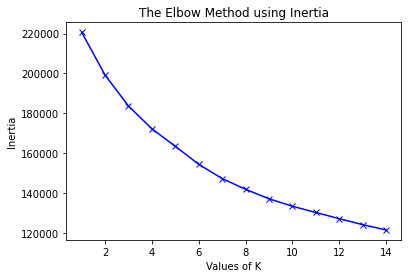

In [46]:
vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
index = 0

for group in vehicle_classes:
    
    distortions = [] 
    inertias = []
    mapping1 = {}
    mapping2 = {} 
    K = range(1,15) 

    X = group.values[:,:]
    X = np.nan_to_num(X)
    cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset
    
    for k in K: 

        #Building and fitting the model 
        kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=50)
        kmeanModel.fit(cluster_dataset)     
      
        distortions.append(sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cluster_dataset.shape[0]) 
        inertias.append(kmeanModel.inertia_) 
  
        mapping1[k] = sum(np.min(cdist(cluster_dataset, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cluster_dataset.shape[0] 
        mapping2[k] = kmeanModel.inertia_ 
    
    print(vehicle_classes_name[index])
    index += 1
    
    for key,val in mapping1.items(): 
        print(str(key)+' : '+str(val)) 
        
    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.title('The Elbow Method using Distortion') 
    plt.show() 
    
    for key,val in mapping2.items(): 
        print(str(key)+' : '+str(val)) 
    
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show()    

In [15]:
from sklearn.preprocessing import StandardScaler

k_values = [5,5,6,6,5,6,6]
index = 0

for group in vehicle_classes:
    X = group.values[:,:]
    X = np.nan_to_num(X)
    cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset

    num_clusters = k_values[index]
    index += 1

    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan",random_state = 2013)
    k_means.fit(cluster_dataset)
    labels = k_means.labels_
    group["Labels"] = labels

In [16]:
sedanCluster = cluster_with_names = cat_to_names(sedan,references)
truckCluster = cluster_with_names = cat_to_names(truck,references)
suvCluster = cluster_with_names = cat_to_names(suv,references)
wagonCluster = cluster_with_names = cat_to_names(wagon,references)
vanCluster = cluster_with_names = cat_to_names(van,references)
coupeCluster = cluster_with_names = cat_to_names(coupe,references)
convertibleCluster = cluster_with_names = cat_to_names(convertible,references)

In [17]:
truckCluster

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,job_assign,Labels
0,FORD,F150,2007,15001.0,0,0,0 - 20000,F,Fifties,UNITED STATES,"Entertainers and Performers, Sports and Relate...",1
1,NISSAN,FRONTIER,2012,20001.0,0,1,20001 - 40000,M,Twenties,JAPAN,Bakers,4
2,FORD,F150,2006,15001.0,0,1,40001 - 60000,U,Twenties,UNITED STATES,Glaziers,2
3,TOYOTA,TUNDRA,2009,20001.0,1,1,60001 - 80000,M,Thirties,JAPAN,First-Line Supervisors of Construction Trades ...,4
4,NISSAN,FRONTIER,2009,20001.0,0,1,40001 - 60000,F,Twenties,JAPAN,Real Estate Sales Agents,4
...,...,...,...,...,...,...,...,...,...,...,...,...
28762,TOYOTA,TUNDRA,2004,15001.0,0,1,40001 - 60000,M,Thirties,JAPAN,Exercise Physiologists,4
28763,CHEVROLET,SILVERADO 1500,2011,20001.0,0,1,40001 - 60000,F,Twenties,UNITED STATES,"Carpet, Floor, and Tile Installers and Finishers",0
28764,FORD,F150,2009,20001.0,1,1,100001 - 120000,M,Forties,UNITED STATES,Sales Engineers,3
28765,TOYOTA,TACOMA,2007,15001.0,0,1,20001 - 40000,M,Twenties,JAPAN,"Cutters and Trimmers, Hand",4


In [18]:
truckCluster[truckCluster.Labels==0].groupby('purchase_model').count().sort_values(by='purchase_make', ascending = False)
#cluster_df.groupby('Labels').mean()

,purchase_make,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,job_assign,Labels
purchase_model,,,,,,,,,,,
SILVERADO 1500,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747,3747
SIERRA 1500,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312
AVALANCHE 1500,578,578,578,578,578,578,578,578,578,578,578
SILVERADO 2500,70,70,70,70,70,70,70,70,70,70,70
CANYON,54,54,54,54,54,54,54,54,54,54,54
MARK LT,33,33,33,33,33,33,33,33,33,33,33
SONOMA,18,18,18,18,18,18,18,18,18,18,18
SILVERADO 1500 HD,13,13,13,13,13,13,13,13,13,13,13
L200,10,10,10,10,10,10,10,10,10,10,10


In [19]:
truck.groupby('Labels').mean()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,job_assign
Labels,,,,,,,,,,,
0,34.883310,547.123544,2008.687800,18422.007539,0.425291,0.771933,4.273132,2.086532,6.119945,2.000000,520.131254
1,17.003285,204.879175,2008.813652,18184.975178,0.413944,0.000000,3.593721,2.074284,6.210805,2.384194,513.984851
2,23.655317,182.735392,2007.379887,14707.391574,0.394027,0.997114,3.827875,2.108642,6.108065,2.000144,521.935651
3,20.312773,245.136652,2010.914320,28269.544228,0.683856,0.895478,7.585085,2.056327,6.028163,2.052360,457.542443
4,12.611790,196.727505,2008.520533,18155.772769,0.491513,1.000000,4.886111,2.108779,6.116262,3.000000,502.368498


In [20]:
truckCluster.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,job_assign
Labels,,,,,,,,,,,
0,CHEVROLET,SILVERADO 1500,2011,20001.0,0,1,40001 - 60000,M,Forties,UNITED STATES,General Internal Medicine Physicians
1,FORD,F150,2010,15001.0,0,0,?,M,Forties,UNITED STATES,General Internal Medicine Physicians
2,FORD,RAM 1500,2008,15001.0,0,1,40001 - 60000,M,Forties,UNITED STATES,General Internal Medicine Physicians
3,FORD,F150,2012,25001.0,1,1,60001 - 80000,M,Forties,UNITED STATES,"Physicians, All Other; and Ophthalmologists, E..."
4,TOYOTA,TACOMA,2007,15001.0,0,1,40001 - 60000,M,Forties,JAPAN,"Physicians, All Other; and Ophthalmologists, E..."


In [21]:
sorted(references['purchase_model'].items(), key=lambda x: x[1])

[('C350', 1),
 ('MONTANA', 2),
 ('300', 3),
 ('5-Sep', 4),
 ('SUNFIRE', 5),
 ('GALANT', 6),
 ('CC', 7),
 ('ALTIMA', 8),
 ('X6 HYBRID', 9),
 ('VERSA NOTE', 10),
 ('LUCERNE', 11),
 ('300M', 12),
 ('ACCORD', 13),
 ('L300', 14),
 ('STS', 15),
 ('i-280', 16),
 ('E55 AMG', 17),
 ('S55 AMG', 18),
 ('BONNEVILLE', 19),
 ('TAHOE', 20),
 ('M5', 21),
 ('G500', 22),
 ('CLS550', 23),
 ('CL550', 24),
 ('ESCALADE HYBRID', 25),
 ('VUE HYBRID', 26),
 ('RODEO', 27),
 ('CADENZA', 28),
 ('C/V', 29),
 ('NV 2500', 30),
 ('NAVIGATOR', 31),
 ('SILVERADO 3500', 32),
 ('E320', 33),
 ('C320', 34),
 ('SLK55 AMG', 35),
 ('VERONA', 36),
 ('SUBURBAN 1500', 37),
 ('IMPALA', 38),
 ('SEDONA', 39),
 ('SL55 AMG', 40),
 ('CONTINENTAL GT', 41),
 ('XK8', 42),
 ('VENZA', 43),
 ('NAVIGATOR L', 44),
 ('C70', 45),
 ('HIGHLANDER HYBRID', 46),
 ('G25', 47),
 ('ECLIPSE', 48),
 ('E350', 49),
 ('9-2X', 50),
 ('AVALON', 51),
 ('MALIBU CLASSIC', 52),
 ('Z4', 53),
 ('MONTE CARLO', 54),
 ('OUTBACK', 55),
 ('SLK250', 56),
 ('COOPER', 57),

In [22]:
references['purchase_model']

{'128': 339,
 '135': 510,
 '1M': 279,
 '200': 525,
 '3-Sep': 162,
 '300': 3,
 '300 C SRT': 144,
 '300M': 12,
 '300ZX': 208,
 '320': 67,
 '325': 462,
 '328': 529,
 '330': 295,
 '335': 143,
 '335 HYBRID': 615,
 '350Z': 491,
 '370Z': 71,
 '4RUNNER': 422,
 '5-Sep': 4,
 '500': 240,
 '525': 548,
 '528': 239,
 '530': 534,
 '535': 220,
 '540': 590,
 '545': 178,
 '550': 377,
 '626': 205,
 '640': 369,
 '640 B640': 288,
 '645': 187,
 '650': 175,
 '740': 226,
 '745': 470,
 '750': 300,
 '750 HYBRID': 118,
 '760': 585,
 '9-2X': 50,
 '911': 451,
 'A3': 194,
 'A4': 262,
 'A5': 392,
 'A6': 530,
 'A7': 156,
 'A8': 526,
 'ACADIA': 338,
 'ACCENT': 391,
 'ACCORD': 13,
 'ACCORD CROSSTOUR': 160,
 'ACCORD HYBRID': 59,
 'AERIO': 274,
 'ALERO': 227,
 'ALLROAD': 584,
 'ALPINA B7': 304,
 'ALTIMA': 8,
 'ALTIMA HYBRID': 100,
 'AMANTI': 177,
 'ARMADA': 312,
 'ASCENDER': 591,
 'ASCENDER EXT': 92,
 'ASPEN': 428,
 'ASPEN HYBRID': 275,
 'ASTRA': 498,
 'ASTRO': 244,
 'ATS': 133,
 'AURA': 405,
 'AURA HYBRID': 374,
 'AUROR

In [23]:
export_groups = [sedanCluster,truckCluster,suvCluster,wagonCluster,vanCluster,coupeCluster,convertibleCluster]

In [24]:
cluster_names = ['sedanCluster','truckCluster','suvCluster','wagonCluster','vanCluster','coupeCluster'
                        ,'convertibleCluster']
index = 0
for group in export_groups:
    for x in group.Labels.unique():
        group[group.Labels==x].to_csv(cluster_names[index]+str(x)+'.csv', index = False)
    index += 1